In [1]:
#libraries
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from PIL import Image
import math
# imports
import os, sys

# third party imports
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler,random_split
!pip install torchinfo
from torchinfo import summary
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix


In [2]:
#Define transform for dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
batch_size = 64
#Set train and test data Loader
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 203603892.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115038645.61it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67198727.10it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19559064.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
#Weight initialization function
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)
  elif classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data,0,0.03)

In [11]:
# Constants to use
num_channels = 1
noise_size = 128
image_size = 28
real_label = 1
fake_label = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#A generator using ConvTranspose layers
class CGenerator(nn.Module):
    def __init__(self, size_noise,num_channels=32):
        super(CGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(size_noise, 1024, 2, 1, 0, bias=False),#outputs(1024,2,2) images
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 2, 1, 0, bias=False),#outputs(512,3,3) images
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),#outputs(256,6,6)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),#outputs(128,12,12)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),#outputs(64,24,24)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 5, 1, 0, bias=False),#outputs(1,28,28)
            nn.Tanh()
        )

    def forward(self, noise):
        img = self.net(noise)
        return img

In [8]:
# See that the sizes i chose actually work
test1 = nn.ConvTranspose2d(noise_size, 1024, 2, 1, 0, bias=False)
test2 = nn.ConvTranspose2d(1024, 512, 2, 1, 0, bias=False)
test3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
test4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
test5 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
test6 = nn.ConvTranspose2d(64, 1, 5, 1, 0, bias=False)
random = torch.randn(1,noise_size,1,1)
print(random.shape)
out1 = test1(random)
print(out1.shape)
out2 = test2(out1)
print(out2.shape)
out3 = test3(out2)
print(out3.shape)
out4 = test4(out3)
print(out4.shape)
out5 = test5(out4)
print(out5.shape)
out6 = test6(out5)
print(out6.shape)



torch.Size([1, 128, 1, 1])
torch.Size([1, 1024, 2, 2])
torch.Size([1, 512, 3, 3])
torch.Size([1, 256, 6, 6])
torch.Size([1, 128, 12, 12])
torch.Size([1, 64, 24, 24])
torch.Size([1, 1, 28, 28])


torch.Size([1, 1, 28, 28])


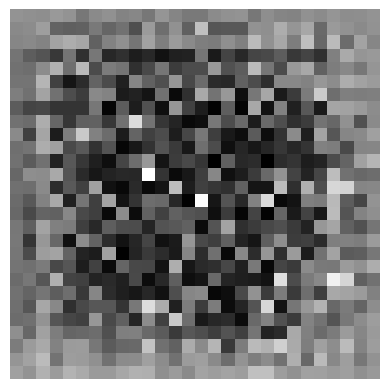

In [9]:
#Demonsration of output, random weights
cgen = CGenerator(noise_size)
cgen.apply(weight_init)
torch.manual_seed(11)
random = torch.randn(1,noise_size,1,1)
out = cgen(random)
print(out.shape)
img = out.squeeze().detach().cpu().numpy()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# A simple Conv net to be the discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(num_channels,32,3,2,1,bias = True),
        nn.LeakyReLU(0.2,True),
        nn.Conv2d(32,64,3,2,1,bias = True),
        nn.LeakyReLU(0.2,True),
        nn.Conv2d(64,128,3,2,1,bias = True),
        nn.LeakyReLU(0.2,True),
        nn.Flatten(),
        nn.Linear(4*4*128,4*128),
        nn.ReLU(True),
        nn.Linear(4*128,128),
        nn.ReLU(True),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    validity = self.net(x)
    return validity

In [13]:
# Summary of Discriminator
test = torch.randn((64,1,28,28)).to(device)
disc = Discriminator()
summary(disc,(1,1,28,28),verbose=2)
out = disc(test).view(-1)
label = torch.full((64,),real_label, dtype=torch.float)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─0.weight                                                    ├─288
│    └─0.bias                                                      ├─32
│    └─2.weight                                                    ├─18,432
│    └─2.bias                                                      ├─64
│    └─4.weight                                                    ├─73,728
│    └─4.bias                                                      ├─128
│    └─7.weight                                                    ├─1,048,576
│    └─7.bias                                                      ├─512
│    └─9.weight                                                    ├─65,536
│    └─9.bias                                                      ├─128
│    └─11.weight                          

In [ ]:
# The main training function
def train_loop(train_loader,gen,disc,gen_opt,disc_opt,criterion,num_epochs,device,patience = None):
  """
  Train_loader: Data loader for the images
  Gen: generator
  disc: discriminator
  gen_opt: an optimizer for the generator
  disc_opt: an optimizer for the discriminator
  criterion: loss to use
  num_epochs: how many epochs to train
  Device: what to train on (cpu,cuda...)
  Patience(optional): early stopping patience
  """
  g_loss = [] #save generator loss
  d_loss = [] #save discriminator loss
  status_image = [] #save status image to check how th generator progresses
  fixed_noise = torch.randn(1,noise_size,1,1).to(device) #Fixed noise for status

  # for early stopping
  count_patience = 0
  best_error = 100

  start_time = time.time()# to check time
  print(f"moving everything to {device}")
  print(f"noise device: {fixed_noise.device}")
  gen.to(device)
  print(f"gen device: {gen.net[0].weight.device}")
  disc.to(device)
  print(f"disc device: {disc.net[0].weight.device}")

  for epoch in range(num_epochs):
    counter = 0
    for batch,labels in train_loader:
      batch = batch.to(device)
      # print(batch.device)

      disc.zero_grad()
      label = torch.full((batch.shape[0],),real_label, dtype=torch.float).to(device)
      # print(batch.shape[0])
      # print("real data ready")
      out = disc(batch).view(-1)
      # print("got output")
      err_disc_real = criterion(out,label)
      # print("calc crit")
      err_disc_real.backward()
      # print("did back")

      mean_d_real = out.mean().item()
      # print("ran real data")


      noise = torch.randn(batch_size,noise_size,1,1).to(device)
      # print(noise.shape)
      fake_image = gen(noise)
      label.fill_(fake_label)
      # print("fake data ready")

      out = disc(fake_image.detach()).view(-1)
      err_disc_fake = criterion(out,label)
      err_disc_fake.backward()
      mean_d_fake = out.mean().item()
      # print("ran fake data")

      error_both = err_disc_real + err_disc_fake

      disc_opt.step()

      gen.zero_grad()
      label.fill_(real_label)
      out = disc(fake_image).view(-1)

      gen_error = criterion(out,label)
      gen_error.backward()

      gen_mean = out.mean().item()
      # print("check gen")
      gen_opt.step()

      if counter % 150 == 0:
        time_from_start = time.time()-start_time
        mins = time_from_start // 60
        seconds = time_from_start % 60
        print(f"[{int(mins)}m, {seconds:.4f}s][{epoch+1}/{num_epochs}] [{counter}/{len(train_loader)}] Loss discriminator = {error_both.item():.4f}, Loss Generator = {gen_error.item():.4f}")

      if counter == 500:
        with torch.no_grad():
          fake = gen(fixed_noise).detach()
          status_image.append(fake.squeeze().cpu().numpy())

      g_loss.append(gen_error.item())
      d_loss.append(error_both.item())
      counter += 1
    time_from_start = time.time()-start_time
    mins = time_from_start // 60
    seconds = time_from_start % 60
    print(f"Finished {epoch+1} epoch, time since start:{int(mins)}m,{seconds:.3f}s")

    if patience != None:
      if error_both+gen_error < best_error:
        print("found better model!")
        best_error = error_both+gen_error
        # Should put your own path to save
        #torch.save(disc, '/content/drive/MyDrive/Assignments/assignment4/mnist_disc.pth')
        #torch.save(gen, '/content/drive/MyDrive/Assignments/assignment4/mnist_gen.pth')
        count_patience = 0
      else:
        count_patience +=1

      if count_patience == patience:
        return g_loss,d_loss,status_image

  return g_loss,d_loss,status_image

In [ ]:
# Set and initialize everything for training.
genarator = CGenerator(noise_size)
genarator.apply(weight_init)
discriminator = Discriminator()
discriminator.apply(weight_init)
gen_opt = optim.SGD(genarator.parameters(),lr=0.003)
disc_opt = optim.SGD(discriminator.parameters(),lr=0.003)
crit = nn.BCELoss()
print(device)

cuda


In [ ]:
# Start training loop, i found that 50 epochs are ok, a bit more and the model collapses
lists = train_loop(train_loader,genarator,discriminator,gen_opt,disc_opt,crit,10,device)

moving everytghin to cuda
noise device: cuda:0
gen device: cuda:0
disc device: cuda:0
, 0.0563s][1/50] [0/937] Loss discriminator = 1.3864, Loss Generator = 0.6915
, 7.6129s][1/50] [150/937] Loss discriminator = 1.3862, Loss Generator = 0.6919
, 13.5706s][1/50] [300/937] Loss discriminator = 1.3860, Loss Generator = 0.6922
, 20.2318s][1/50] [450/937] Loss discriminator = 1.3859, Loss Generator = 0.6925
, 26.2302s][1/50] [600/937] Loss discriminator = 1.3857, Loss Generator = 0.6928
, 32.6515s][1/50] [750/937] Loss discriminator = 1.3855, Loss Generator = 0.6930
, 39.5760s][1/50] [900/937] Loss discriminator = 1.3853, Loss Generator = 0.6933
Finished 1 epoch, time since start:0m,41.377s
, 41.4192s][2/50] [0/937] Loss discriminator = 1.3852, Loss Generator = 0.6933
, 48.0295s][2/50] [150/937] Loss discriminator = 1.3849, Loss Generator = 0.6935
, 54.0057s][2/50] [300/937] Loss discriminator = 1.3846, Loss Generator = 0.6938
, 0.4852s][2/50] [450/937] Loss discriminator = 1.3842, Loss Gen

In [ ]:
#torch.save(discriminator, '/content/drive/MyDrive/Assignments/assignment4/mnist_disc.pth')
#torch.save(genarator, '/content/drive/MyDrive/Assignments/assignment4/mnist_gen.pth')

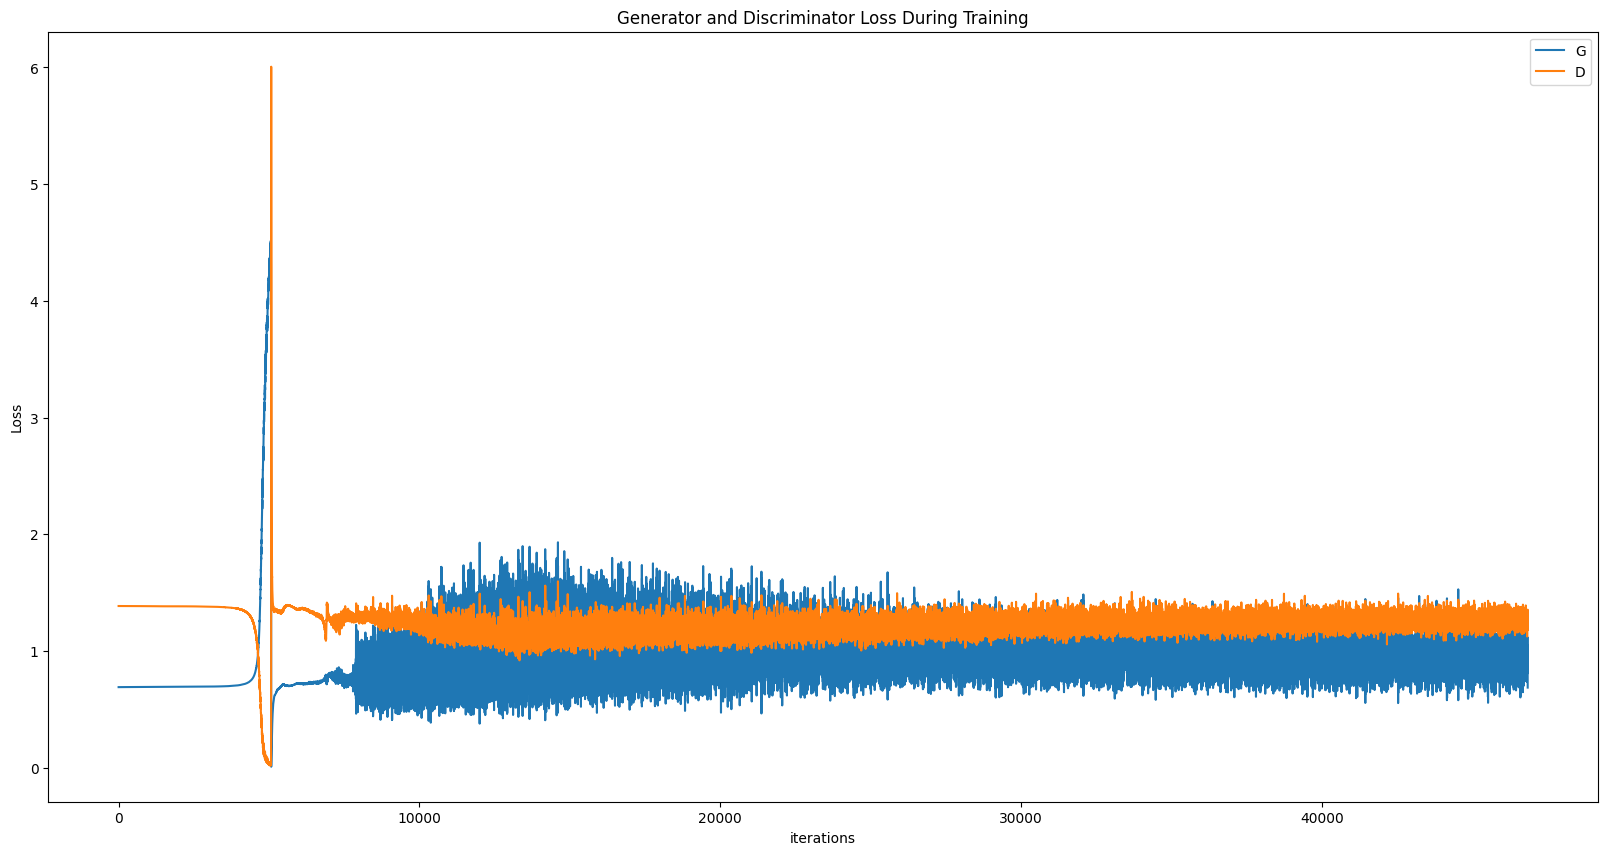

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lists[0],label="G")
plt.plot(lists[1],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
images = lists[2]
print(len(images))

100


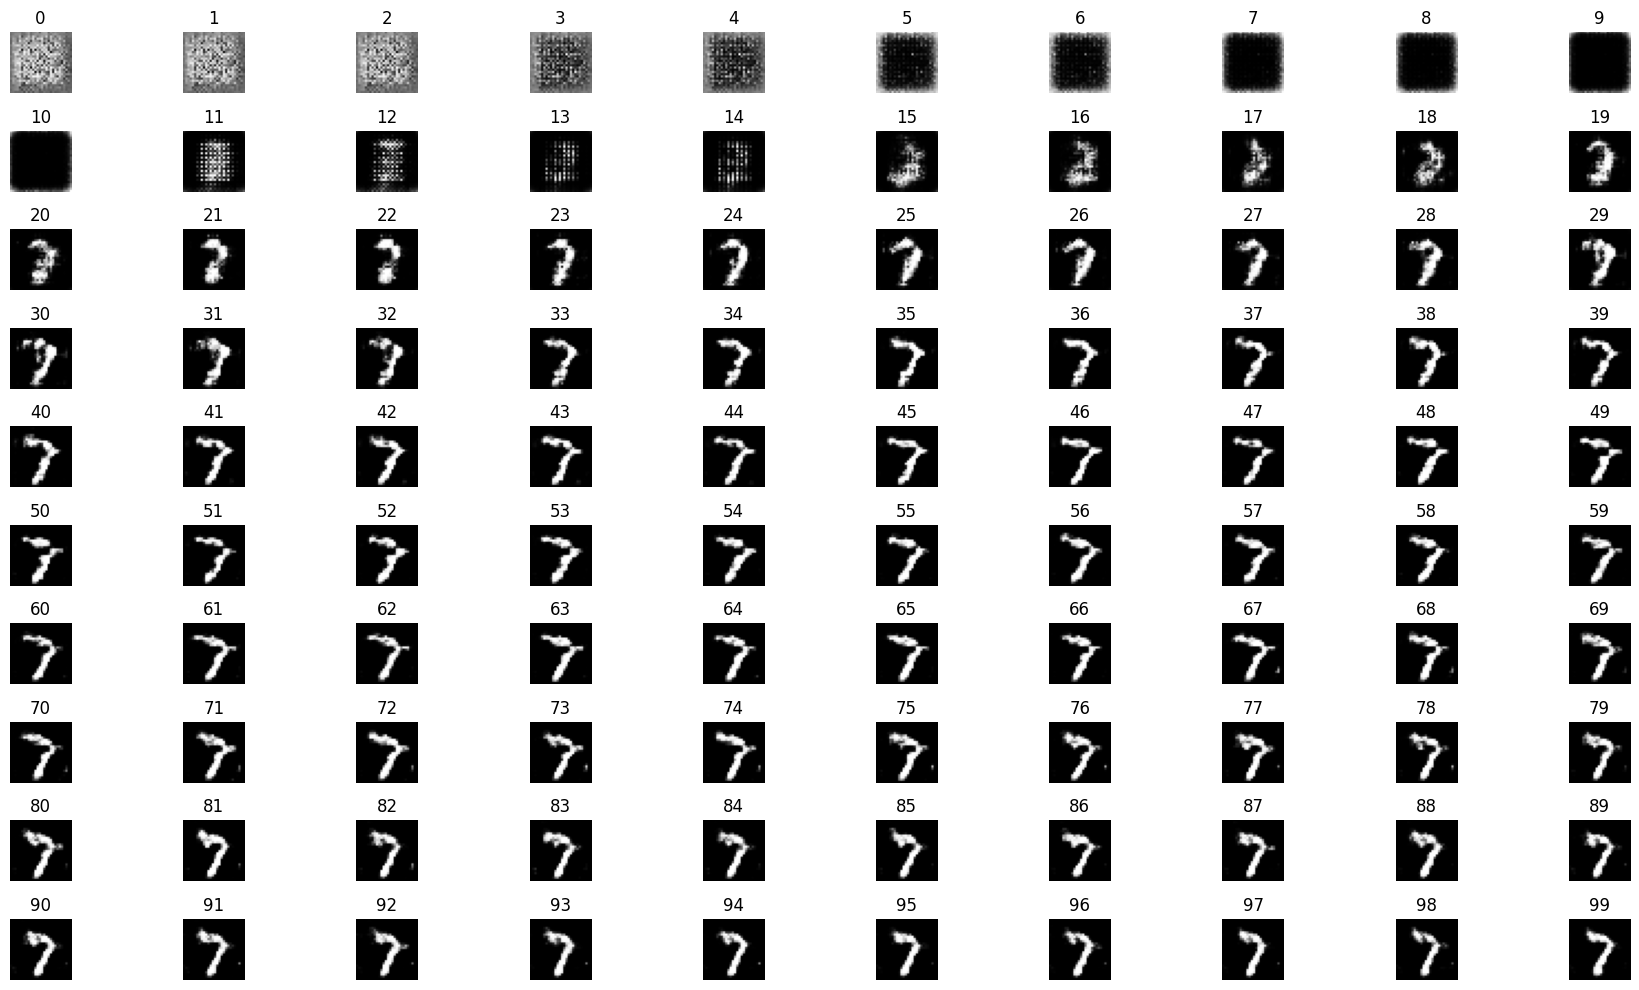

In [ ]:
# Create a grid of subplots
num_images = len(images)
cols = int(np.ceil(np.sqrt(num_images)))
rows = int(np.ceil(num_images / cols))
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

# Iterate over the images and display them with titles
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i],cmap='gray')
        ax.set_title(str(i))
    ax.axis('off')

# Adjust spacing and layout
plt.tight_layout()
plt.show()

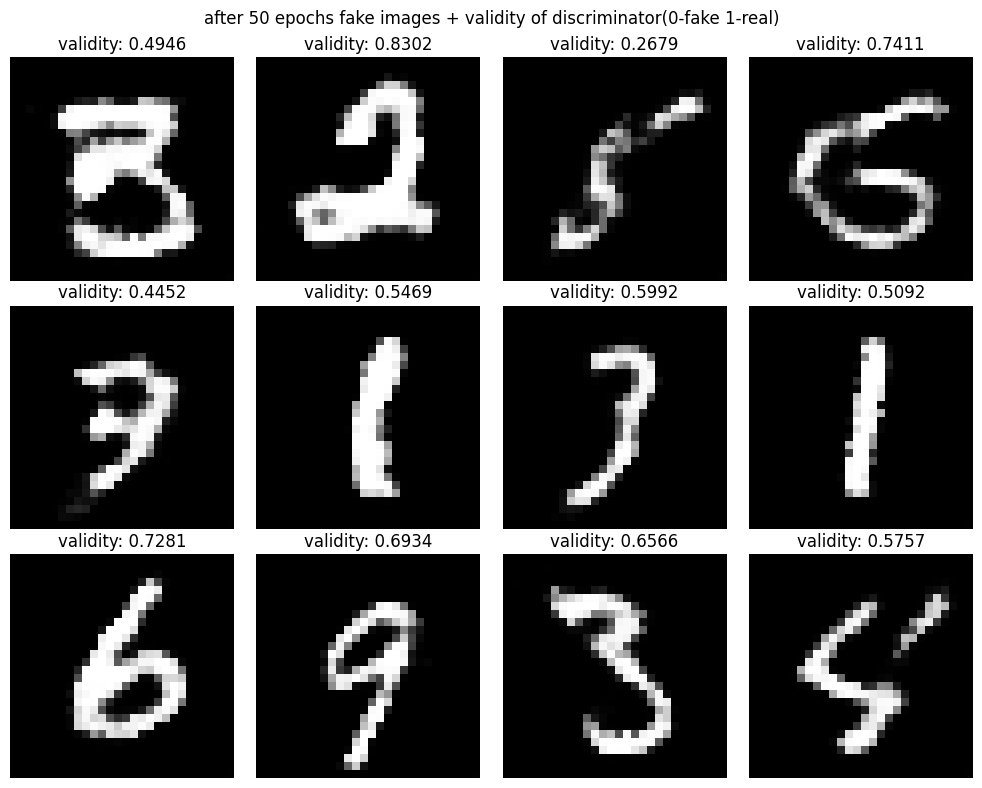

In [ ]:
rand_10 = torch.randn(12,noise_size,1,1).to(device)
# print(rand_10)
images_check = genarator(rand_10)
sure = discriminator(images_check)
# Create a grid of subplots
images_check = images_check.detach().squeeze().cpu().numpy()
num_images = len(images_check)
cols = int(np.ceil(np.sqrt(num_images)))
rows = int(np.ceil(num_images / cols))
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
fig.suptitle("after 50 epochs fake images + validity of discriminator(0-fake 1-real)")
# Iterate over the images and display them with titles
for i, ax in enumerate(axes.flat):
    if i < len(images_check):
        ax.imshow(images_check[i],cmap='gray')
        title = f"validity: {sure[i].item():.4f}"
        ax.set_title(str(title))
    ax.axis('off')

# Adjust spacing and layout
plt.tight_layout()
plt.show()

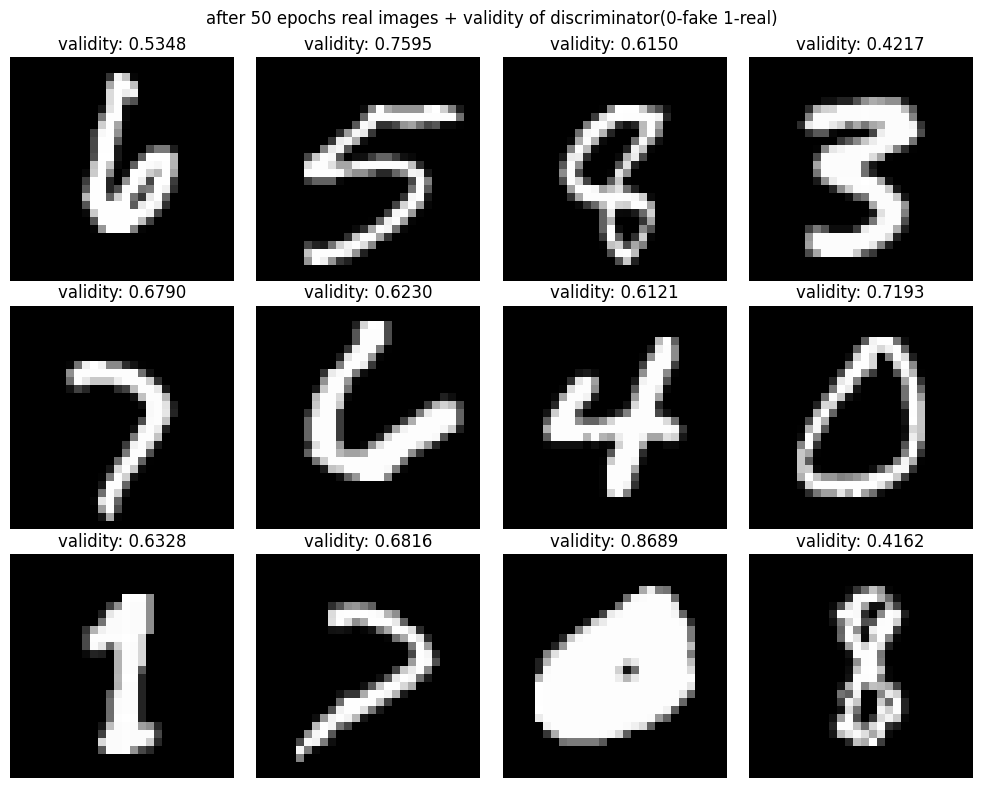

In [ ]:
batch,labels = next(iter(train_loader))
# print(rand_10)
images_check = batch[:12].to(device)
sure = discriminator(images_check)
# Create a grid of subplots
images_check = images_check.detach().squeeze().cpu().numpy()
num_images = len(images_check)
cols = int(np.ceil(np.sqrt(num_images)))
rows = int(np.ceil(num_images / cols))
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
fig.suptitle("after 50 epochs real images + validity of discriminator(0-fake 1-real)")
# Iterate over the images and display them with titles
for i, ax in enumerate(axes.flat):
    if i < len(images_check):
        ax.imshow(images_check[i],cmap='gray')
        title = f"validity: {sure[i].item():.4f}"
        ax.set_title(str(title))
    ax.axis('off')

# Adjust spacing and layout
plt.tight_layout()
plt.show()